In [4]:
from google.colab import drive
drive.mount('/content/gdrive') # for google colab. adjust accordingly

Mounted at /content/gdrive


In [5]:
import spacy
import pickle
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from typing import List, Tuple, Dict
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence

### constants ###

n_extra_tokens = 4
UNK_IDX = 0 
PADDING_IDX = 1 
BOS_IDX = 2
EOS_IDX = 3 

PARENT_DIR = '/content/gdrive/MyDrive/CS287_Research_Project/Jennas_Code/' # for google colab. adjust accordingly

In [6]:
from typing import List, Tuple, Dict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
from torch import nn, optim
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss

from torchtext.data.metrics import bleu_score

In [7]:
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

True
Tesla P100-PCIE-16GB
cuda


In [8]:
import sys  
sys.path.insert(0, PARENT_DIR)

from EncoderLSTM import *
from DecoderLSTM import *
from Seq2Seq import *
from train import *

from load_data import load_pickled_dataloaders
mt_train_ds, mt_val_ds, mt_test_ds, mt_train_dl, mt_val_dl, mt_test_dl = load_pickled_dataloaders(parent_dir = PARENT_DIR)

In [9]:
import sys  
sys.path.insert(0, PARENT_DIR)

from load_lm import *
lm = load_lm()
lm.generate(torch.Tensor([[1,2,3]]).to(device))

tensor([[ -5.7043,  -9.4225,  -9.7102,  ...,  -7.6038, -10.0476, -10.0659]],
       device='cuda:0')

# How much weight is on correst POS in LM output

In [ ]:
batch = next(iter(mt_train_dl))
input_seqs = batch[0][0]
output_seqs = batch[1][0]
input_pos = batch[2][0]
output_pos = batch[3][0]

In [23]:
int_to_pos = {v:k for k, v in mt_train_ds.pos_map.items()}
source_int_to_vocab = {v:k for k, v in mt_train_ds.source_vocab.items()}
target_int_to_vocab = {v:k for k, v in mt_train_ds.target_vocab.items()}

print('Source:', ' '.join([source_int_to_vocab[int(idx)] for idx in input_seqs]))
print('Target:', ' '.join([target_int_to_vocab[int(idx)] for idx in output_seqs]))
print()

for i in range(1, len(input_seqs)-1):
  context = input_seqs[:i]
  target = input_seqs[i]
  probs = np.exp(
    lm.generate(input_seqs[:i].to(device).unsqueeze(0)).to('cpu')
  )[0]
  select = mt_train_ds.source_pos_idx[int(input_pos[i])]
  print(
      'i =', i, '\t',
      'target POS:', int_to_pos[int(input_pos[i])], '\t',
      round(sum(np.array(probs)*np.array(select)), 4), 'probability put on correct POS'
  )

Source: <BOS> <UNK> können im körper sehr leicht <UNK> werden <EOS>
Target: <BOS> it s very easy to look at metal artifacts that we can show inside of the body <EOS>

i = 1 	 target POS: NOUN 	 0.3681 probability put on correct POS
i = 2 	 target POS: AUX 	 0.0478 probability put on correct POS
i = 3 	 target POS: ADP 	 0.0079 probability put on correct POS
i = 4 	 target POS: NOUN 	 0.007 probability put on correct POS
i = 5 	 target POS: ADV 	 0.0016 probability put on correct POS
i = 6 	 target POS: ADV 	 0.0008 probability put on correct POS
i = 7 	 target POS: VERB 	 0.0007 probability put on correct POS
i = 8 	 target POS: AUX 	 0.0001 probability put on correct POS


Does probability put on correct POS depend on *part of speech* or *amount of context*?

For each token in each source sequence in the train and validation datasets, pass context into the language model to generate a probability distribution over the vocabulary. Record the position, the word itself, the true part of speech and part of speech , and the amount of probability weight the language model put on that part of speech.

In [26]:
# log = {
#     'seq' : [],
#     'i' : [],
#     'word': [],
#     'true_pos' : [],
#     'true_pos_map': [],
#     'prob_true_pos' : [],
#     'prob_true_pos_map' : []
# }

# int_to_pos = {v:k for k, v in mt_train_ds.pos_map.items()}
# source_int_to_vocab = {v:k for k, v in mt_train_ds.source_vocab.items()}
# target_int_to_vocab = {v:k for k, v in mt_train_ds.target_vocab.items()}

# seq = 1
# # takes about 30 minutes
# for batch in tqdm(iter(mt_train_dl)):
#   input_seqs = batch[0][0]
#   output_seqs = batch[1][0]
#   input_pos = batch[2][0]
#   output_pos = batch[3][0]

#   for i in range(1, len(input_seqs)-1):
#     context = input_seqs[:i]
#     target = input_seqs[i]
#     probs = np.exp(
#       lm.generate(input_seqs[:i].to(device).unsqueeze(0)).to('cpu')
#     )[0]
#     select = mt_train_ds.source_pos_idx[int(input_pos[i])]

#     # pos according to pos_map
#     true_pos_map = mt_train_ds.source_vocab_to_tags[int(input_seqs[i])]
#     select2 = mt_train_ds.source_pos_idx[int(true_pos_map)]

#     log['seq'].append(seq)
#     log['i'].append(i)
#     log['word'].append(source_int_to_vocab[int(input_seqs[i])])
#     log['true_pos'].append(int(input_pos[i]))
#     log['true_pos_map'].append(true_pos_map)
#     log['prob_true_pos'].append(sum(np.array(probs)*np.array(select)))
#     log['prob_true_pos_map'].append(sum(np.array(probs)*np.array(select2)))
      
#   seq += 1

100%|██████████| 20611/20611 [30:02<00:00, 11.43it/s]


In [27]:
# val_log = {
#     'seq' : [],
#     'i' : [],
#     'word': [],
#     'true_pos' : [],
#     'true_pos_map': [],
#     'prob_true_pos' : [],
#     'prob_true_pos_map' : []
# }

# seq = 1
# for batch in tqdm(iter(mt_val_dl)):
#   input_seqs = batch[0][0]
#   output_seqs = batch[1][0]
#   input_pos = batch[2][0]
#   output_pos = batch[3][0]

#   for i in range(1, len(input_seqs)-1):
#     context = input_seqs[:i]
#     target = input_seqs[i]
#     probs = np.exp(
#       lm.generate(input_seqs[:i].to(device).unsqueeze(0)).to('cpu')
#     )[0]
#     select = mt_train_ds.source_pos_idx[int(input_pos[i])]

#     # pos according to pos_map
#     true_pos_map = mt_train_ds.source_vocab_to_tags[int(input_seqs[i])]
#     select2 = mt_train_ds.source_pos_idx[int(true_pos_map)]

#     val_log['seq'].append(seq)
#     val_log['i'].append(i)
#     val_log['word'].append(source_int_to_vocab[int(input_seqs[i])])
#     val_log['true_pos'].append(int(input_pos[i]))
#     val_log['true_pos_map'].append(true_pos_map)
#     val_log['prob_true_pos'].append(sum(np.array(probs)*np.array(select)))
#     val_log['prob_true_pos_map'].append(sum(np.array(probs)*np.array(select2)))
      
#   seq += 1

100%|██████████| 89/89 [00:09<00:00,  9.59it/s]


In [28]:
# log_train_df = pd.DataFrame(log)
# log_val_df = pd.DataFrame(val_log)

In [30]:
# log_train_df[['true_pos_text']] = [int_to_pos[pos] for pos in log_train_df.true_pos]
# log_train_df[['true_pos_map_text']] = [int_to_pos[pos] for pos in log_train_df.true_pos_map]

# log_val_df[['true_pos_text']] = [int_to_pos[pos] for pos in log_val_df.true_pos]
# log_val_df[['true_pos_map_text']] = [int_to_pos[pos] for pos in log_val_df.true_pos_map]

In [ ]:
# log_train_df.to_csv(PARENT_DIR+'/log_train_df.csv')
# log_val_df.to_csv(PARENT_DIR+'/log_val_df.csv')

In [10]:
log_train_df = pd.read_csv(PARENT_DIR+'/log_train_df.csv')
log_val_df = pd.read_csv(PARENT_DIR+'/log_val_df.csv')

In [11]:
log_train_df.head()

,Unnamed: 0,seq,i,word,true_pos,true_pos_map,prob_true_pos,prob_true_pos_map,true_pos_text,true_pos_map_text
0,0,1,1,in,4,4,0.016885,0.016885,ADP,ADP
1,1,1,2,gewisser,9,9,0.088235,0.088235,ADJ,ADJ
2,2,1,3,weise,8,8,0.185199,0.185199,NOUN,NOUN
3,3,1,4,wird,11,11,0.007430,0.007430,AUX,AUX
4,4,1,5,der,7,7,0.001685,0.001685,DET,DET


In [12]:
sum(log_train_df.true_pos == log_train_df.true_pos_map)/len(log_train_df.true_pos)

0.8783167508392052

# Does correctness vary by part of speech

In [13]:
import matplotlib.pyplot as plt

In [14]:
summ_train = log_train_df[['true_pos_map_text','prob_true_pos_map']].groupby('true_pos_map_text').describe()
summ_val = log_val_df[['true_pos_map_text','prob_true_pos_map']].groupby('true_pos_map_text').describe()

summ_train, summ_val

(                  prob_true_pos_map            ...                    
                               count      mean  ...       75%       max
 true_pos_map_text                              ...                    
 ADJ                         10634.0  0.009441  ...  0.000920  0.103494
 ADP                         30844.0  0.002987  ...  0.000570  0.234174
 ADV                         34896.0  0.023911  ...  0.020852  0.183008
 AUX                         23461.0  0.006212  ...  0.015137  0.170071
 CCONJ                       11786.0  0.008910  ...  0.003565  0.441398
 DET                         41894.0  0.004720  ...  0.002300  0.230633
 NOUN                        77970.0  0.030491  ...  0.002313  0.368089
 NUM                          3722.0  0.002813  ...  0.000854  0.035463
 PART                         7650.0  0.000223  ...  0.000004  0.092435
 PRON                        44629.0  0.707590  ...  0.999960  1.000000
 PROPN                        3666.0  0.007427  ...  0.001505  0

In [22]:
log_val_df.prob_true_pos_map.mean(), log_val_df.prob_true_pos_map.median()

(0.11102849365799125, 2.738883874202378e-05)

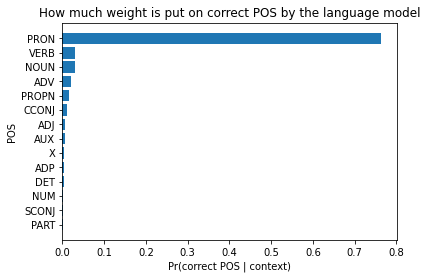

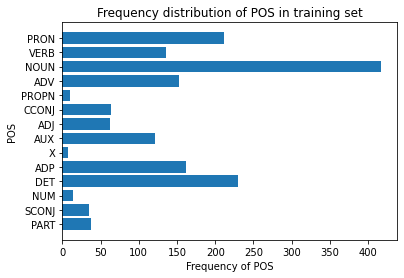

In [17]:
sorted_pos = [v for k, v in sorted(zip(summ_val['prob_true_pos_map']['mean'], summ_val.index))]

plt.barh(sorted_pos, summ_val['prob_true_pos_map']['mean'][sorted_pos],)
plt.xlabel("Pr(correct POS | context)")
plt.ylabel("POS")
plt.title("How much weight is put on correct POS by the language model")
plt.show()
b
plt.barh(sorted_pos, summ_val['prob_true_pos_map']['count'][sorted_pos])
plt.xlabel("Frequency of POS")
plt.ylabel("POS")
plt.title("Frequency distribution of POS in training set")
plt.show()

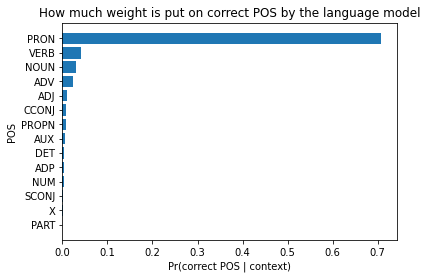

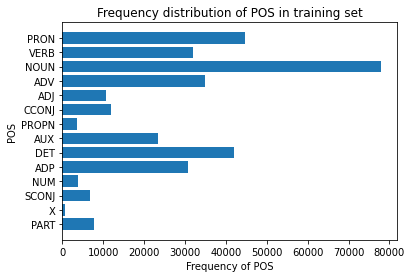

In [51]:
sorted_pos = [v for k, v in sorted(zip(summ_train['prob_true_pos_map']['mean'], summ_train.index))]

plt.barh(sorted_pos, summ_train['prob_true_pos_map']['mean'][sorted_pos],)
plt.xlabel("Pr(correct POS | context)")
plt.ylabel("POS")
plt.title("How much weight is put on correct POS by the language model")
plt.show()

plt.barh(sorted_pos, summ_train['prob_true_pos_map']['count'][sorted_pos])
plt.xlabel("Frequency of POS")
plt.ylabel("POS")
plt.title("Frequency distribution of POS in training set")
plt.show()

# Does correctness vary by position

In [71]:
summ_pos_train = log_train_df[log_train_df.i < 32][['i','prob_true_pos_map']].groupby('i').describe()
summ_pos_val = log_val_df[log_val_df.i < 32][['i','prob_true_pos_map']].groupby('i').describe()

summ_pos_train, summ_pos_val

(   prob_true_pos_map                      ...                                      
                count      mean       std  ...           50%           75%       max
 i                                         ...                                      
 1            20611.0  0.063407  0.093150  ...  1.971714e-02  1.193855e-01  0.368089
 2            20513.0  0.123877  0.110264  ...  8.449717e-02  2.196064e-01  0.366179
 3            20338.0  0.152390  0.199802  ...  6.341042e-02  1.999093e-01  0.933329
 4            20067.0  0.137937  0.291555  ...  1.283705e-02  4.637738e-02  0.991158
 5            19448.0  0.118723  0.309088  ...  2.957688e-03  9.572729e-03  0.997213
 6            18522.0  0.117241  0.316048  ...  7.996535e-04  2.535341e-03  0.999374
 7            17349.0  0.114757  0.315418  ...  2.593802e-04  8.092147e-04  0.999657
 8            16173.0  0.114749  0.316194  ...  9.299447e-05  3.018488e-04  0.999891
 9            14984.0  0.112866  0.313783  ...  3.898244e-05  1.3

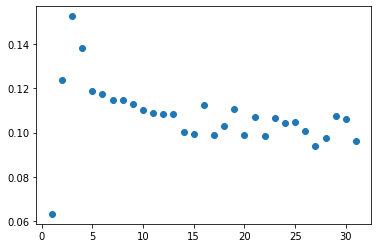

In [81]:
plt.scatter(summ_pos_train['prob_true_pos_map'].index, summ_pos_train['prob_true_pos_map']['mean'])
plt.show()

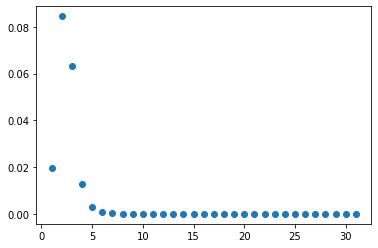

In [86]:
plt.scatter(summ_pos_train['prob_true_pos_map'].index, summ_pos_train['prob_true_pos_map']['50%'])
plt.show()

# Does translation get proper part of speech distribution

In [11]:
with open(PARENT_DIR + '/jennas_model_seqmix.pickle', 'rb') as f:
  model_soft = pickle.load(f)

In [12]:
model_soft.encoder.lstm.flatten_parameters()
model_soft.decoder.lstm.flatten_parameters()

In [14]:
candidate_text, reference_text = translate_corpus(
    mt_train_ds.target_vocab, 
    mt_test_dl, 
    model_soft, 
    eos_idx = EOS_IDX, 
    bos_idx = BOS_IDX,
    padding_idx = PADDING_IDX
)

In [101]:
[z for z in zip([' '.join(c) for c in candidate_text], [' '.join(r[0]) for r in reference_text])]

[('<BOS> and then we started to do this the same model <EOS>',
  '<BOS> and so we started planning these <EOS>'),
 ('<BOS> now he got a lot of a lot of his old and he said no and he s going to go up <EOS>',
  '<BOS> well he mentioned some and some fish meals and then he said chicken <EOS>'),
 ('<BOS> the people who have to be the best and he was the best and the family s the father s the whole thing to the door <EOS>',
  '<BOS> the power of music brought him back into a family of musicians that understood him that recognized his and respected him <EOS>'),
 ('<BOS> he was the idea of this <EOS>',
  '<BOS> he had had the experience <EOS>'),
 ('<BOS> and when i look at the same thing <EOS>',
  '<BOS> and as i move around my finger shifts <EOS>'),
 ('<BOS> when we do it as we need to be able to the traffic with the other <EOS>',
  '<BOS> when we looked at how feelings with income <EOS>'),
 ('<BOS> okay let me take a little bit more old <EOS>',
  '<BOS> well let me work up some blood for yo

POS tags for candidate and reference

In [ ]:
candidate_text[0]

NameError: ignored

In [ ]:
candidate_pos = [
  [mt_train_ds.target_vocab_to_tags[token] for token in seq]
  for seq in candidate_text
]
reference_pos = [
  [mt_train_ds.target_vocab_to_tags[token] for token in seq[0]]
  for seq in reference_text
]

Distribution of POS in each sentence

In [ ]:
# use sorted_pos as order within each list, highest to lowest freq
reference_pos_dist = [
  [np.mean(np.array(seq_pos) == pos) for pos in sorted_pos[::-1]]
  for seq_pos in reference_pos
]
candidate_pos_dist = [
  [np.mean(np.array(seq_pos) == pos) for pos in sorted_pos[::-1]]
  for seq_pos in candidate_pos
]

In [ ]:
sorted_pos[::-1]

['PRON',
 'NOUN',
 'VERB',
 'ADV',
 'ADJ',
 'PROPN',
 'CCONJ',
 'ADP',
 'AUX',
 'X',
 'DET',
 'NUM',
 'PART',
 'SCONJ']

Compare distributions in each sequence reference vs candidate

In [ ]:
pos_dist_diffs = [
  np.array(reference_pos_dist[seq]) - np.array(candidate_pos_dist[seq])
  for seq in range(len(reference_pos_dist))
]

In [ ]:
pos_dist_diffs[0]

First idx: amount higher reference sequence's proportion of pronouns is than that of candidate sequence